In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/To The Moon - From Reddit Comments to Stocks/Code/LSTMR"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/17-IViQXtJ7E70aIa03YJMvzoEf76guys/To The Moon - From Reddit Comments to Stocks/Code/LSTMR


In [4]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [5]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y'])

df

,adjclose_20_X,adjclose_19_X,adjclose_18_X,adjclose_17_X,adjclose_16_X,adjclose_15_X,adjclose_14_X,adjclose_13_X,adjclose_12_X,adjclose_11_X,adjclose_10_X,adjclose_9_X,adjclose_8_X,adjclose_7_X,adjclose_6_X,adjclose_5_X,adjclose_4_X,adjclose_3_X,adjclose_2_X,adjclose_1_X,adjclose_2_Y,adjclose_3_Y,adjclose_4_Y,adjclose_5_Y,adjclose_6_Y,adjclose_7_Y,adjclose_8_Y,adjclose_9_Y,adjclose_10_Y,adjclose_11_Y,adjclose_12_Y,adjclose_13_Y,adjclose_14_Y,adjclose_15_Y,adjclose_16_Y,adjclose_17_Y,adjclose_18_Y,adjclose_19_Y,adjclose_20_Y,adjclose_21_Y
0,52.026543,51.579323,50.899178,51.113464,49.315266,49.231415,48.467411,50.414680,50.787373,49.864975,50.628979,50.535812,50.843269,51.076195,51.495464,51.365028,51.961319,52.138344,51.691128,50.321518,46.610138,47.982403,48.602737,49.740036,47.268070,48.790726,49.016304,48.593346,48.828323,48.865921,48.734329,49.016304,48.236179,46.995499,47.221077,46.967300,49.223080,49.345276,50.144196,50.943123
1,410.399994,412.209991,403.850006,407.559998,402.260010,401.640015,394.000000,405.670013,422.100006,418.700012,414.880005,411.429993,410.630005,422.489990,425.000000,422.890015,416.989990,418.190002,423.570007,424.119995,395.029999,408.260010,406.559998,410.619995,410.309998,415.850006,422.600006,420.929993,413.359985,416.309998,421.739990,429.119995,424.959991,420.950012,405.570007,409.929993,411.890015,408.670013,414.369995,398.019989
2,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271
3,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271
4,38.873425,39.189323,38.214558,38.683891,38.115276,38.187477,38.061119,38.268715,38.377018,38.286758,37.330048,37.781326,37.573742,37.727173,38.115276,37.799374,37.582760,37.212711,37.095379,36.598965,33.853710,34.880959,34.944592,35.153675,35.180950,35.135498,34.962769,34.917316,35.162773,35.871841,36.108204,36.135464,35.799118,35.417305,35.771847,36.090015,36.171829,37.799068,37.862701,36.917271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940780,5.650000,6.020000,5.830000,6.150000,5.700000,5.500000,5.260000,5.240000,5.240000,5.170000,4.980000,4.880000,4.980000,4.940000,4.720000,4.500000,4.580000,4.510000,4.600000,4.560000,5.370000,5.450000,5.560000,5.570000,5.490000,5.330000,5.530000,5.400000,5.520000,5.500000,5.420000,5.450000,5.330000,5.380000,5.440000,5.500000,5.250000,5.190000,5.070000,5.120000
940781,4.270000,4.500000,4.620000,4.510000,4.590000,4.440000,4.330000,4.200000,4.330000,4.240000,4.080000,4.050000,4.080000,3.900000,3.890000,3.800000,3.850000,3.680000,3.680000,3.560000,4.480000,4.470000,4.770000,4.820000,4.890000,4.900000,4.940000,5.200000,5.470000,5.430000,5.530000,5.800000,5.650000,5.520000,5.230000,6.450000,9.520000,12.990000,9.010000,9.400000
940782,15.030000,15.360000,15.120000,15.160000,14.990000,15.150000,14.240000,14.240000,14.610000,14.760000,14.570000,14.320000,14.650000,14.730000,15.130000,14.860000,15.080000,14.810000,14.270000,13.630000,21.860001,21.865000,21.570000,22.770000,22.700001,22.980000,23.540001,22.830000,22.340000,22.190001,22.190001,22.400000,22.600000,22.639999,22.100000,21.660000,21.360001,21.150000,21.000000,21.590000
940783,28.073952,29.172199,29.535013,30.162582,28.730938,28.191620,28.436766,28.417154,28.495598,28.

In [6]:
# Print the colum names
df.columns.values

array(['adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X',
       'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X',
       'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X',
       'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X',
       'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X',
       'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
       'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
       'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
       'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
       'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y'],
      dtype=object)

In [7]:
# Find the min and max at 1-4 business week intervals
df['5day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmin(axis=1)

df['10day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmin(axis=1)

df['15day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmin(axis=1)

df['20day_min'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmin(axis=1)

df['5day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y']].idxmax(axis=1)

df['10day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y']].idxmax(axis=1)

df['15day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y']].idxmax(axis=1)

df['20day_max'] = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                     'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y',
                      'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
                      'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
                      'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                      'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y',
                      'adjclose_20_Y', 'adjclose_21_Y']].idxmax(axis=1)

# Extract the day number and convert to int
df['5day_min'] = df['5day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_min'] = df['10day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_min'] = df['15day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_min'] = df['20day_min'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['5day_max'] = df['5day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['10day_max'] = df['10day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['15day_max'] = df['15day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)
df['20day_max'] = df['20day_max'].str.replace(r'[^0-9]+', '', regex=True).astype(int)

In [8]:
# # Get the X-variable columns
df_X = df[['adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
            'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
            'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
            'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
            'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
            'adjclose_1_X']].to_numpy()

# # Get the Y-variable columns
df_Y = df[['adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y',
            'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y',
            'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y',
            'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y',
            'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y',
            '5day_min', '10day_min', '15day_min', '20day_min', '5day_max',
            '10day_max', '15day_max', '20day_max']].to_numpy()

# Clear up memory
del df
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[ 52.02654266  51.57932281  50.89917755 ...  52.13834381  51.69112778
   50.32151794]
 [410.3999939  412.20999146 403.8500061  ... 418.19000244 423.57000732
  424.11999512]
 [ 38.87342453  39.18932343  38.21455765 ...  37.21271133  37.09537888
   36.59896469]
 ...
 [124.01503754 127.77788544 125.05794525 ... 128.88563538 127.82733154
  128.85595703]
 [ 22.59499931  20.13999939  18.60000038 ...  21.10000038  21.59000015
   24.35000038]
 [  7.61999989   7.9000001    7.36999989 ...   7.1500001    7.07999992
    6.69999981]]
[[ 3.8900001   3.82999992  3.95000005 ...  4.40999985  4.36000013
   4.3499999 ]
 [21.7001915  21.67077446 21.96074867 ... 21.76743317 22.11540222
  21.88342476]
 [ 1.35000002  1.38        1.80999994 ...  2.04999995  2.05999994
   2.1099999 ]
 ...
 [15.02999973 15.35999966 15.11999989 ... 14.81000042 14.27000046
  13.63000011]
 [28.07395172 29.17219925 29.5350132  ... 22.61213112 24.74979019
  24.33794785]
 [ 9.03999996  8.5         7.46999979 ...  6.          6.61999

In [9]:
# Normalize data
scaler = MinMaxScaler()

n_features = 5

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)
#xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], xtrain_scale.shape[1], n_features)
xtrain_scale = xtrain_scale.reshape(xtrain_scale.shape[0], 4, n_features)

print(scaler.fit(X_test))
xval_scale=scaler.transform(X_test)
#xval_scale = xval_scale.reshape(xval_scale.shape[0], xval_scale.shape[1], n_features)
xval_scale = xval_scale.reshape(xval_scale.shape[0], 4, n_features)

print(scaler.fit(y_train))
ytrain_scale=scaler.transform(y_train)

print(scaler.fit(y_test))
yval_scale=scaler.transform(y_test)

# Set input and output dimensions
indim = xtrain_scale.shape[1]
outdim = ytrain_scale.shape[1]

import tensorflow as tf
tf.keras.backend.clear_session()

# Initialize LSTM
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=False, input_shape=(indim, n_features)))
model.add(Dropout(0.2))

# Second LSTM layer
#model.add(LSTM(units=50, return_sequences=False))
#model.add(Dropout(0.2))

# Third LSTM layer
#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.1))

# Fourth LSTM layer
#model.add(LSTM(units=50))
#model.add(Dropout(0.5))

# Output layer
model.add(Dense(outdim))

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'mae'])

# Train
model.fit(xtrain_scale, ytrain_scale, epochs=10, batch_size=128, verbose=0)

# Predict
ypred = model.predict(xval_scale)

# Scale back to original scale
ypred = scaler.inverse_transform(ypred)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [10]:
ypred.shape

(188157, 28)

In [11]:
# Evaluate RMSE
# Google Colab doesn't compute `squared=False` parameter
rmse = mean_squared_error(y_test, ypred, multioutput='raw_values', squared=False)

# For each value in rmse
for i in range(1, len(rmse)+1):

    # Print the RMSE values for adjClose
    if i < 21:
        print("The RMSE for adjClose_{}_Y = ".format(i+1), rmse[i-1]**0.5)

    # Print the RMSE values for min day
    elif 21 <= i < 25:
        print("The RMSE for {}day_min = ".format((i-20)*5), rmse[i-1]**0.5)

    # Print the RMSE for max day
    else:
        print("The RMSE for {}day_max = ".format((i-24)*5), rmse[i-1]**0.5)

The RMSE for adjClose_2_Y =  55.88864586574501
The RMSE for adjClose_3_Y =  58.0805254390365
The RMSE for adjClose_4_Y =  59.8357855070971
The RMSE for adjClose_5_Y =  60.524544390173055
The RMSE for adjClose_6_Y =  61.326285244250016
The RMSE for adjClose_7_Y =  58.36832684652511
The RMSE for adjClose_8_Y =  60.675760262148394
The RMSE for adjClose_9_Y =  61.509752708697576
The RMSE for adjClose_10_Y =  62.00211263239811
The RMSE for adjClose_11_Y =  63.78780168216213
The RMSE for adjClose_12_Y =  67.27283931458403
The RMSE for adjClose_13_Y =  70.28462502283338
The RMSE for adjClose_14_Y =  72.02878095578453
The RMSE for adjClose_15_Y =  76.2944436051623
The RMSE for adjClose_16_Y =  78.05124371741007
The RMSE for adjClose_17_Y =  78.90400725849828
The RMSE for adjClose_18_Y =  80.67935114047695
The RMSE for adjClose_19_Y =  81.93972382442206
The RMSE for adjClose_20_Y =  85.0796940626849
The RMSE for adjClose_21_Y =  84.58361657652645
The RMSE for 5day_min =  1.5471741981881513
The 

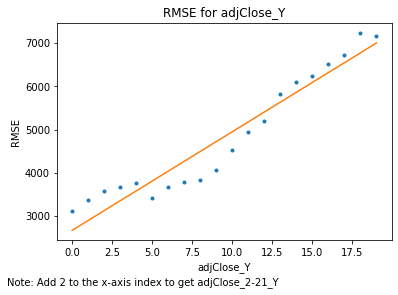

In [12]:
# Plot the RMSE for adjClose
x = np.arange(20)
y = rmse[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('RMSE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('RMSE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()

In [13]:
# Evaluate MAE
mae = mean_absolute_error(y_test, ypred, multioutput='raw_values')

# For each value in mae
for i in range(1, len(mae)+1):

    # Print the MAE values for adjClose
    if i < 21:
        print("The MAE for adjClose_{}_Y = ".format(i+1), mae[i-1])

    # Print the MAE values for min day
    elif 21 <= i < 25:
        print("The MAE for {}day_min = ".format((i-20)*5), mae[i-1])

    # Print the MAE for max day
    else:
        print("The MAE for {}day_max = ".format((i-24)*5), mae[i-1])

The MAE for adjClose_2_Y =  23.14700842657266
The MAE for adjClose_3_Y =  24.288990014681094
The MAE for adjClose_4_Y =  24.72600778386336
The MAE for adjClose_5_Y =  24.962948447594265
The MAE for adjClose_6_Y =  25.59598378071487
The MAE for adjClose_7_Y =  24.10779484586325
The MAE for adjClose_8_Y =  24.63667748304646
The MAE for adjClose_9_Y =  24.4398540565505
The MAE for adjClose_10_Y =  24.450220278516255
The MAE for adjClose_11_Y =  24.963160007371282
The MAE for adjClose_12_Y =  26.374775841608294
The MAE for adjClose_13_Y =  27.282158142812616
The MAE for adjClose_14_Y =  28.556942552042624
The MAE for adjClose_15_Y =  29.767838697382903
The MAE for adjClose_16_Y =  30.627303621875264
The MAE for adjClose_17_Y =  30.833311311289496
The MAE for adjClose_18_Y =  31.93173380059746
The MAE for adjClose_19_Y =  32.383363013602
The MAE for adjClose_20_Y =  34.356004758664234
The MAE for adjClose_21_Y =  34.28112768035156
The MAE for 5day_min =  1.377841323928526
The MAE for 10day_

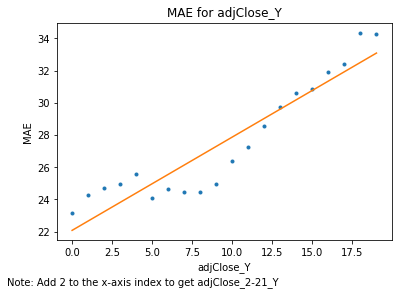

In [14]:
# Plot the MAE for adjClose
x = np.arange(20)
y = mae[0:20]

# Fit with polyfit
b, m = polyfit(x, y, 1)

# Add title and axis names
plt.title('MAE for adjClose_Y')
plt.xlabel('adjClose_Y')
plt.ylabel('MAE')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 2 to the x-axis index to get adjClose_2-21_Y',
            horizontalalignment='left')

plt.plot(x, y, '.')
plt.plot(x, m*x+b, '-')
plt.show()